### Restart the kernel each time you want to generate a new set. Otherwise, for some reason, the parallel workers will use the same variable values they had on their first execution.

In [1]:
from joblib import Parallel, delayed
import multiprocessing

from os import listdir
from os.path import isfile, join
import numpy as np

from scipy.ndimage import rotate

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#['stable', 'slip-tra', 'slip-rot']
LABELS = ['n', 's', 'e', 'w', 'cw', 'aw', 't']
OBJECTS = ['pen', 'case', 'sponge', 'hd' #basic
        #, 'cardboard', 'bottle' #more solids
        #, 'brush', 'screw' #small
        #, 'plate', 'bubbles', 'striped' #textures
        ]
SET_TYPE = 'train' #'train' 'test' 'test/textures'
SENSOR_ID = 1 #0 - ff, 1 - mf, 2 - th
FINGERS = 3
ELECTRODES = 24
TIME_WINDOW = 5
STEP = 0
SAMPLE_WITH_STEP = STEP > 0

TACTILE_IMAGE_ROWS = 12
TACTILE_IMAGE_COLS = 11
ELECTRODES_INDEX_ROWS = np.array([0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 2, 3, 3, 5])
ELECTRODES_INDEX_COLS = np.array([1, 2, 0, 1, 3, 0, 1, 4, 2, 1, 9, 8, 10, 9, 7, 10, 9, 6, 8, 9, 5, 4, 6, 5])

# Returns the values of the 8 neighbours of a given cell.
# This method is meant to be called with the gaps in tactile cells.
def get_neighbours(tactile_image, cell_x, cell_y):
    pad = 2
    padded_x = cell_x + pad
    padded_y = cell_y + pad

    padded = np.pad(tactile_image, ((pad, pad), (pad, pad)), 'constant') #0s

    neighbours_xs = [padded_x - 1, padded_x - 1, padded_x - 1, 
                     padded_x, padded_x, 
                     padded_x + 1, padded_x + 1, padded_x + 1]
    neighbours_ys = [padded_y - 1, padded_y, padded_y + 1,
                     padded_y - 1, padded_y + 1,
                     padded_y - 1, padded_y, padded_y + 1]
    num_neighbours = len(neighbours_xs)
    neighbours = []

    for i in range(num_neighbours):
        some_x = neighbours_xs[i]
        some_y = neighbours_ys[i]
        neighbours.append(padded[some_x, some_y])

    return neighbours

def ceros_2_mean(tactile_image):
    prev_tactile_image = np.copy(tactile_image)
    cero_xs, cero_ys = np.where(tactile_image == 0)

    for i in range(len(cero_xs)):
        cell_x = cero_xs[i]
        cell_y = cero_ys[i]
        cell_neighs = get_neighbours(prev_tactile_image, cell_x, cell_y)
        cell_neighs = [value for value in cell_neighs if value > 0.0]

        if len(cell_neighs) > 0:
            tactile_image[cell_x, cell_y] = np.mean(cell_neighs)

    return tactile_image    

def create_finger_tactile_image(finger_biotac):
    tactile_image = np.zeros(shape=(TACTILE_IMAGE_ROWS, TACTILE_IMAGE_COLS))
    tactile_image[ELECTRODES_INDEX_ROWS, ELECTRODES_INDEX_COLS] = finger_biotac

    # Strategy 2 - Fill with neighbours average
    tactile_image = ceros_2_mean(tactile_image)

    # Repeat in case that there were cells with no values as neighbours
    # as in the 12x11 distribution so they are all filled now
    if np.min(tactile_image) == 0.0:
        tactile_image = ceros_2_mean(tactile_image)

    # Feature scaling
    tactile_image = (tactile_image - np.min(tactile_image)) / (np.max(tactile_image) - np.min(tactile_image))

    return tactile_image

def process_label_files(label_index, sample_with_step = False):
    TYPE = LABELS[label_index]

    DIR = './npys/' + TYPE + '/'
    OUT_SET = './datasets/' + SET_TYPE + '/' + TYPE

    STATE = label_index
    
    # Find files
    all_files = [f for f in listdir(DIR) if isfile(join(DIR, f))]
    files = []
    
    for file in all_files:
        if any(obj in file for obj in OBJECTS):
            files.append(file)
            
    print(files)
    
    dataset_np = np.zeros([0, FINGERS, ELECTRODES])
    print(dataset_np.shape)
    
    for file in files:
        data_np = np.load(DIR + file)

        dataset_np = np.append(dataset_np, data_np, axis=0)

    print(dataset_np.shape)
    
    # We are going to work with one sensor
    dataset_np = dataset_np[:, SENSOR_ID, :]
    print(dataset_np.shape)
    
    if not sample_with_step:
        # Since we are going to use TIME_WINDOW-frames windows
        # remove the left recordings
        dataset_np = dataset_np[0:int((dataset_np.shape[0] / TIME_WINDOW)) * TIME_WINDOW]
        print(dataset_np.shape)

        # Reshape in SAMPLES, TIME_WINDOW, ELECTRODES
        dataset_np = dataset_np.reshape([-1, TIME_WINDOW, ELECTRODES])
        print(dataset_np.shape)
    else:
        samples_idx = np.array(range(dataset_np.shape[0]))
        elements = len(samples_idx)

        print('STEP', STEP, 'TIME_WINDOW', TIME_WINDOW)

        segments = int(elements / (STEP * TIME_WINDOW))

        print('Segments', segments)

        dataset_aux = np.zeros([0, TIME_WINDOW, ELECTRODES])

        for i in range(segments):
            init = i * STEP * TIME_WINDOW
            end = init + STEP * TIME_WINDOW - STEP + 1
            sequence = samples_idx[init:end:STEP]

            index = []

            for j in sequence:
                index.append(samples_idx[j:j + STEP])

            index = np.array(index).T
            
            dataset_aux = np.concatenate((dataset_aux, dataset_np[index]))

        dataset_np = dataset_aux
        print(dataset_np.shape)

    tactile_images = np.zeros(shape=(dataset_np.shape[0], dataset_np.shape[1], TACTILE_IMAGE_ROWS, TACTILE_IMAGE_COLS))
    #tactile_images_flip = np.zeros(shape=(dataset_np.shape[0], dataset_np.shape[1], TACTILE_IMAGE_ROWS,
    #                                      TACTILE_IMAGE_COLS))
    #tactile_images_flip2 = np.zeros(shape=(dataset_np.shape[0], dataset_np.shape[1], TACTILE_IMAGE_ROWS,
    #                                       TACTILE_IMAGE_COLS))
    #tactile_images_rotate10 = np.zeros(shape=(dataset_np.shape[0], dataset_np.shape[1], TACTILE_IMAGE_ROWS,
    #                                          TACTILE_IMAGE_COLS))
    #tactile_images_rotate10m = np.zeros(shape=(dataset_np.shape[0], dataset_np.shape[1], TACTILE_IMAGE_ROWS,
    #                                           TACTILE_IMAGE_COLS))

    for sample in range(dataset_np.shape[0]):
        rot = np.random.randint(1, high=11)
        
        for frame in range(dataset_np.shape[1]):
            one_grasp = dataset_np[sample, frame]
            one_tactile_image = create_finger_tactile_image(one_grasp)

            tactile_images[sample, frame] = one_tactile_image
            #tactile_images_flip[sample, frame] = np.fliplr(one_tactile_image)
            #tactile_images_flip2[sample, frame] = np.flipud(one_tactile_image)
            #tactile_images_rotate10[sample, frame] = rotate(one_tactile_image, rot, reshape=False, mode='nearest')
            #tactile_images_rotate10m[sample, frame] = rotate(np.fliplr(one_tactile_image), rot, reshape=False,
            #                                                 mode='nearest')
    
    some_sample = 0
    some_frame = 0

    print(dataset_np[some_sample, some_frame])
    print(tactile_images[some_sample, some_frame])
    
    labels_np = np.ones([dataset_np.shape[0], 1], dtype=int) * STATE
    
    # Concatenate augmented set
    #whole_labels = np.concatenate((labels_np, labels_np, labels_np, labels_np, labels_np), axis=0)
    #whole_images = np.concatenate((tactile_images, tactile_images_flip, tactile_images_flip2, 
                                   #tactile_images_rotate10, tactile_images_rotate10m), axis=0)
    
    whole_labels = labels_np
    whole_images = tactile_images
    
    print('Images set:', tactile_images.shape)
    print('Labels:', labels_np.shape)
    
    # Save files
    if not SAMPLE_WITH_STEP:
        np.save(OUT_SET + '-' + str(TIME_WINDOW) + '-ff-data-image.npy', whole_images)
        np.save(OUT_SET + '-' + str(TIME_WINDOW) + '-ff-labels-image.npy', whole_labels)
    else:
        np.save(OUT_SET + '-' + str(STEP) + '-' + str(TIME_WINDOW) + '-ff-data-image.npy', whole_images)
        np.save(OUT_SET + '-' + str(STEP) + '-' + str(TIME_WINDOW) + '-ff-labels-image.npy', whole_labels)
        
    #return whole_images

In [3]:
cores = multiprocessing.cpu_count()

Parallel(n_jobs=cores)(delayed(process_label_files)(i, sample_with_step = SAMPLE_WITH_STEP) for i in range(len(LABELS)))

[None, None, None, None, None, None, None]

In [5]:
whole_images = process_label_files(0, sample_with_step = SAMPLE_WITH_STEP)

['plate-n_2018-11-19-10-15-51.npy', 'striped-n_2018-11-19-10-42-26.npy', 'bubbles-n_2018-11-19-10-28-11.npy', 'striped-n_2018-11-19-10-42-39.npy', 'plate-n_2018-11-19-10-15-38.npy', 'bubbles-n_2018-11-19-10-28-32.npy', 'plate-n_2018-11-19-10-15-44.npy', 'plate-n_2018-11-19-10-15-57.npy', 'bubbles-n_2018-11-19-10-28-40.npy', 'striped-n_2018-11-19-10-42-33.npy', 'bubbles-n_2018-11-19-10-28-19.npy', 'striped-n_2018-11-19-10-42-20.npy']
(0, 3, 24)
(3324, 3, 24)
(3324, 24)
(3320, 24)
(664, 5, 24)
[3537. 3698. 3541. 3646. 3478. 3510. 3675. 3501. 3415. 3083. 3603. 3708.
 3620. 3539. 3490. 3582. 3557. 3470. 2978. 2722. 3711. 3684. 3690. 3515.]
[[0.82406471 0.82406471 0.90546006 0.98685541 0.9934277  1.
  0.99848332 0.99696663 0.94388271 0.89079879 0.89079879]
 [0.82406471 0.90546006 0.98685541 0.98685541 1.         1.
  1.         0.99696663 0.99696663 0.94388271 0.89079879]
 [0.87451972 0.98685541 0.98685541 0.97977755 0.98634985 1.
  0.98938322 0.98786653 0.99696663 0.99696663 0.92952477]
 [

664


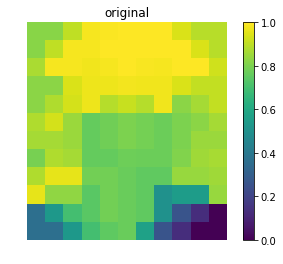

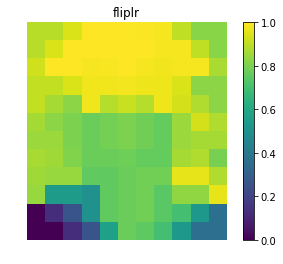

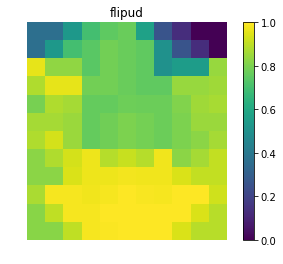

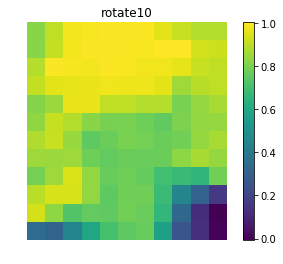

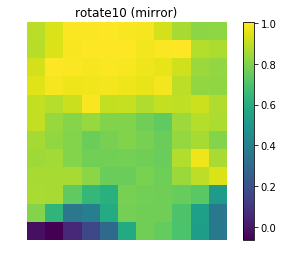

In [8]:
unique = int(whole_images.shape[0] / 5)

print(unique)

index = 0

plt.figure()
plt.imshow(whole_images[0 * unique + index, 0, :, :], interpolation='nearest', )
plt.axis('off')
plt.title('original')
plt.colorbar()

plt.figure()
plt.imshow(whole_images[1 * unique + index, 0, :, :], interpolation='nearest', )
plt.axis('off')
plt.title('fliplr')
plt.colorbar()

plt.figure()
plt.imshow(whole_images[2 * unique + index, 0, :, :], interpolation='nearest', )
plt.axis('off')
plt.title('flipud')
plt.colorbar()

plt.figure()
plt.imshow(whole_images[3 * unique + index, 0, :, :], interpolation='nearest', )
plt.axis('off')
plt.title('rotate10')
plt.colorbar()

plt.figure()
plt.imshow(whole_images[4 * unique + index, 0, :, :], interpolation='nearest', )
plt.axis('off')
plt.title('rotate10 (mirror)')
plt.colorbar()